# Using SHARPy's UVLM to find the lift and drag curve of an aircraft

In this advanced tutorial, we will use SHARPy's UVLM (linear and nonlinear) to find the lift curve slope of an aircraft, and see the effect linearisation has on it.

The problem will be set up as follows:
 
* The aircraft is placed in a steady uniform velocity aligned with the inertial `x` direction.
* The angle of attack of the aircraft will be applied by rotating the aircraft by said angle (changing the `orientation` of the beam in `BeamLoader`)
* The static solution will be computed using `StaticUvlm`
* The forces at this condition will be the output using `AeroForcesCalculator`
* The `LinearAssembler` will be used to linearise the system. Note, we would like the UVLM to be projected onto the structural degrees of freedom thus we need to produce a `LinearAeroelastic` system, from which we will use the linearised UVLM only.
* We will perturb the linearised UVLM to approximate the lift and drag curves in the vicinity of the linearisation angle of attack

## Definitions

The inertial frame G is set up to be with `z` pointing upwards.

The aircraft `A` frame is coincident with the `G` frame when the aircraft is not rotated. `x` is downstream and `y` points towards the right wing.

The stability axis `S` has `x` aligned with the flow, `y` is the same as the aircraft's `y` and `z` completes the set.

Lift and drag are defined as the aerodynamic forces projected onto the stability `z` and `x` axes, respectively. The angle between `x_s` and `x_a` is the angle of attack `alpha`.

## Output forces and frame of reference...

The output forces are defined in the `A` frame, thus they need to be projected onto the `S` frame to get the lift and drag. If using `AeroForcesCalculator` this will be done for you, as `S` will be coincident with `G` if we simply rotate the structure. However, once we perturb the UVLM the stability axes will change.

The lift and drag are defined as 

$$ F^S(\alpha) = C^{SA}(\alpha)F^A $$

where $C^{SA}(\alpha)$ projects a vector in `A` to `S`.

Therefore, perturbations to the lift and drag will result in 

$$\delta F^S = \frac{\partial}{\partial\alpha}\left(C^{SA}F_0^A\right)\delta\alpha + C_0^{SA}\delta F^A $$

The term $\delta F^A$ is actually the output from the UVLM (when expressed in the structural degrees of freedom) and can therefore be computed simply as $\delta F^A = H(0) \delta v^A$, where $H(0)$ is the steady-state transfer function of the UVLM and $\delta v^A$ is the perturbation input in the `A` frame of reference.

These inputs and frames of reference are shown in the figure below




In [4]:
from IPython.display import Image
from IPython.core.display import HTML

In [2]:
Image(filename='./for_deltaalpha.png')

FileNotFoundError: [Errno 2] No such file or directory: './for_deltaalpha.png'

The initial velocity is defined in the inertial frame as $V_0^G = U_\infty[-1, 0, 0]$. The new desired velocity is, for simplicity also expressed in the inertial frame as $V' = U_\infty[-\cos(\delta\alpha), 0, -\sin(\delta\alpha)]$, thus leading to the perturbation velocity $\delta V^G = V' - V_0$. The input to the UVLM will then be $\delta v^A = C^{AG}\delta V^G$.

For this tutorial we will use two scripts:
* One generates a `StaticUvlm` solution and saves the forces using `AeroForcesCalculator` at various angle of attack
* One generates a linearised UVLM system projected onto the structural degrees of freedom at three angles of attack

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import scipy.signal as scsig
import scipy.io as scio
import h5py
import sharpy.utils.h5utils as h5utils
import sharpy.utils.algebra as algebra
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

The results from Script 1 are post-processed and saved to text:

In [3]:
uvlm = np.loadtxt('./07_ForceProfile/results/simple_HALE_uvlm.txt')

A bit of house keeping. We need the dynamic pressure and reference area to compute aerodynamic coefficients

In [5]:
S_ref = 32
u_inf = 10
rho = 1.225
qS = 0.5 * rho * u_inf ** 2 * S_ref

We now scale the resulting forces from `AeroForcesCalculator` with the appropriate factor

In [6]:
uvlm[:, 1:] /= qS

In [7]:
def process_linear(path_to_case, case_name, alpha0, alpha_min, alpha_max, n_evals, return_freq='D'):
    # load the aeroelastic system
    aoasys = scio.loadmat('{:s}/{:s}/{:s}.linss.mat'.format(path_to_case, case_name, case_name))
    # load the linearised uvlm
    uvlmsys = scio.loadmat('{:s}/{:s}/{:s}.uvlmss.mat'.format(path_to_case, case_name, case_name))
    
    
    # we need to compute the steady state transfer function of the discrete time uvlm
    H0 = uvlmsys['C'].dot(np.linalg.inv(np.eye(uvlmsys['A'].shape[0]) - uvlmsys['A']).dot(uvlmsys['B'])) + uvlmsys['D']
    
    cga = algebra.quat2rotation(algebra.euler2quat(np.array([0, alpha0, 0])))

    vx_ind = 20 # x_a input index
    vz_ind = 22 # z_a input index
    
    forces = np.zeros((n_evals, 4))
    for i_alpha, dalpha in enumerate(np.linspace(alpha_min, alpha_max, n_evals)-alpha0):
        alpha = alpha0 + dalpha  # rad
        deuler = np.array([0, dalpha, 0])
        euler0 = np.array([0, alpha0, 0])

        u = np.zeros((uvlmsys['B'].shape[1]))  # input vector
        V0 = np.array([-1, 0, 0], dtype=float) * u_inf  #G
        Vp = u_inf * np.array([-np.cos(dalpha), 0 , -np.sin(dalpha)])  #G
    
        dvg = Vp - V0  # G
        dva = cga.T.dot(dvg)  # A
        dvz = dva[2]
        dvx = dva[0]
        
        # Need to scale the mode shapes by the rigid body mode factor
        u[vx_ind] = dvx / aoasys['mode_shapes'][-9,0]
        u[vz_ind] = dvz / aoasys['mode_shapes'][-7,2]
        
        # and the same with the output forces
        flin = H0.dot(u)[:3].real / aoasys['mode_shapes'][-9,0]  # A
        F0A = aoasys['forces_aero_beam_dof'][0, :3] / aoasys['mode_shapes'][-9,0]  # A - forces at the linearisation
        LD0 = cga.dot(F0A)  # Lift and drag at the linearisation point
    
        forces[i_alpha, 0] = (alpha0 + dalpha) * 180 / np.pi # deg
        LD = LD0 + algebra.der_Ceuler_by_v(euler0, F0A).dot(deuler) + cga.dot(flin)  # stability axes
        forces[i_alpha, 1:] = LD / qS
    
    if return_freq=='freq':
        return H0
    elif return_freq=='D':
        return uvlmsys['D']
    elif return_freq=='B':
        return uvlmsys['B']
    else:
        return forces

In [116]:
linear_systems = []
path_to_systems = './yy_debug_rom/output/'

for alpha in [2, 4]:
    case = {}
    case['alpha0'] = alpha
    case['case_name'] = 'simple_HALE_uvlm_alpha{:04g}_lm1_rom1_nmodes20'.format(case['alpha0']*100)
    case['path'] = path_to_systems + '/' + case['case_name']
    linear_systems.append(case)

In [117]:
linear_systems

[{'alpha0': 2,
  'case_name': 'simple_HALE_uvlm_alpha0200_lm1_rom1_nmodes20',
  'path': './yy_debug_rom/output//simple_HALE_uvlm_alpha0200_lm1_rom1_nmodes20'},
 {'alpha0': 4,
  'case_name': 'simple_HALE_uvlm_alpha0400_lm1_rom1_nmodes20',
  'path': './yy_debug_rom/output//simple_HALE_uvlm_alpha0400_lm1_rom1_nmodes20'}]

In [118]:
for case in linear_systems:
    case['data'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='forces')
#     case['freq'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='freq')
#     case['D'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='D')
#     case['B'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='B')

Alpha0 = 2.0 deg
CL_alpha = 5.856941 / rad
CD_alpha @ alpha0 = 0.037442 / rad
Alpha0 = 4.0 deg
CL_alpha = 5.859295 / rad
CD_alpha @ alpha0 = 0.075245 / rad


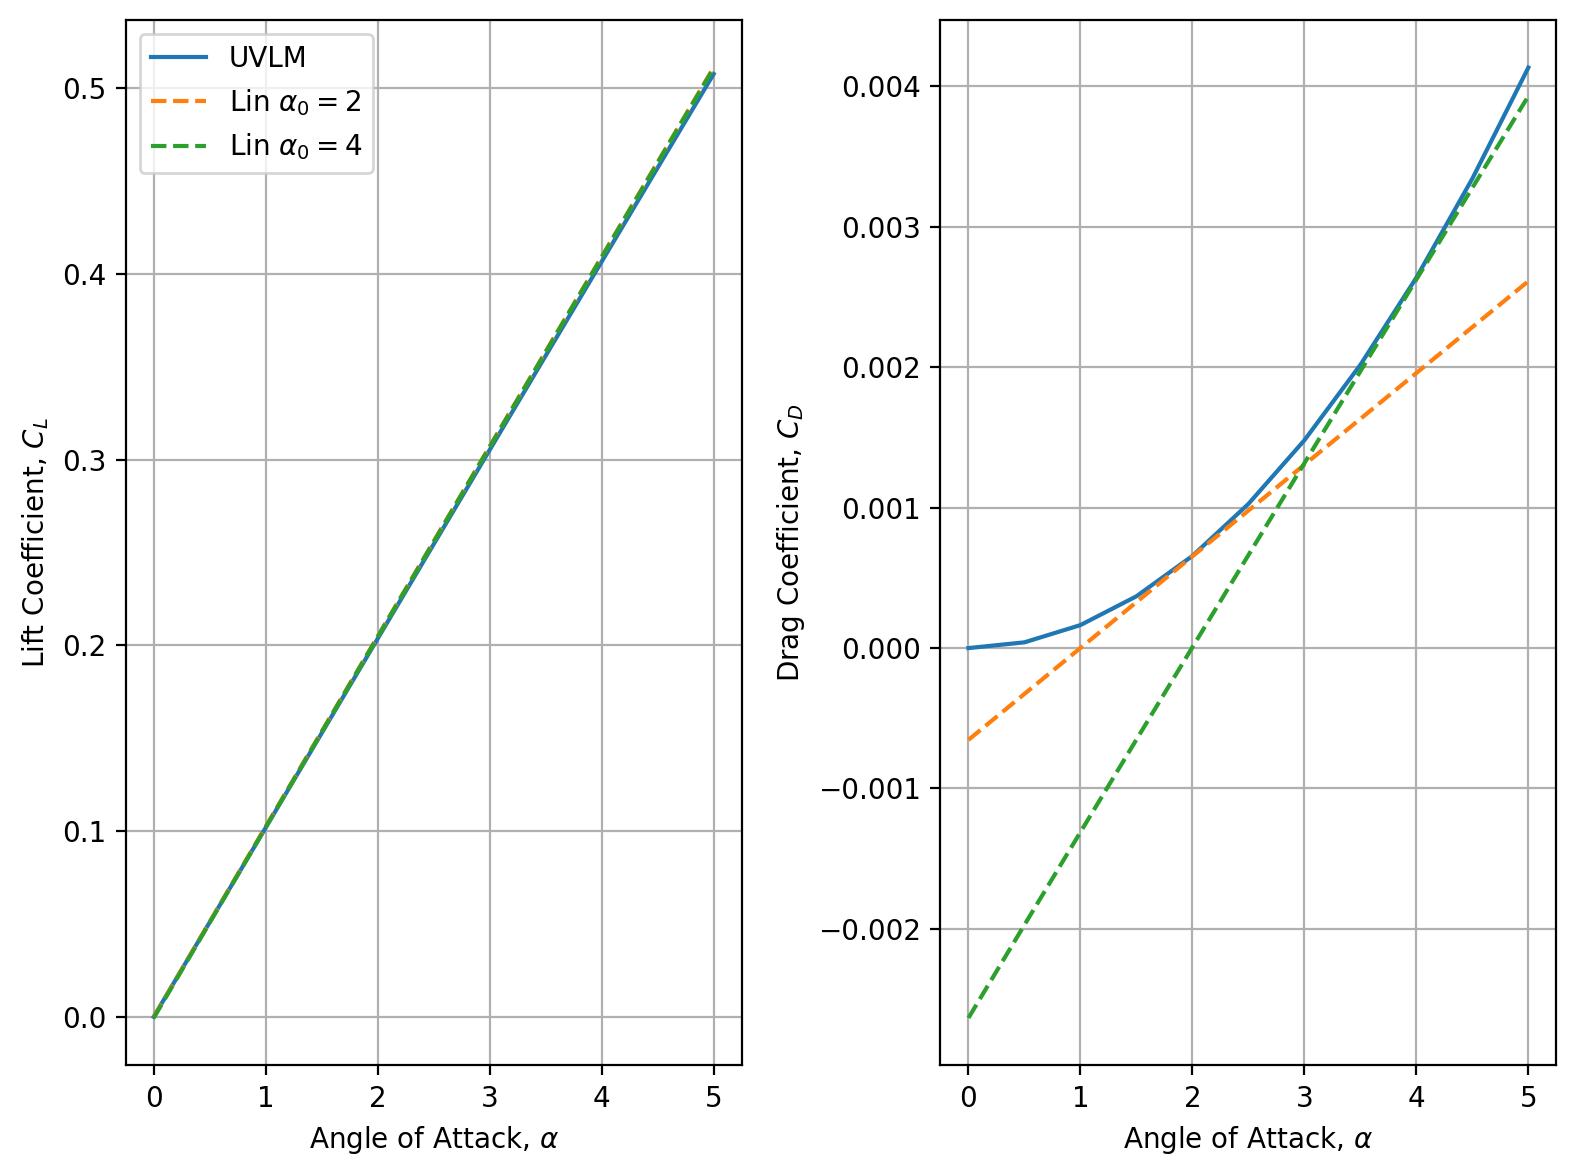

In [119]:
fig, ax = plt.subplots(ncols=2)

ax[0].plot(uvlm[:, 0], uvlm[:, -1], label='UVLM')
ax[1].plot(uvlm[:, 0], uvlm[:, 1])


for case in linear_systems:
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    ax[0].plot(case['data'][:, 0], case['data'][:, -1], ls='--', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
    ax[1].plot(case['data'][:, 0], case['data'][:, 1], ls='--')
    
    cla = (case['data'][-1, -1] - case['data'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
    print('CL_alpha = {:3f} / rad'.format(cla))
    
    cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
    print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

ax[0].set_ylabel('Lift Coefficient, $C_L$')
ax[1].set_ylabel('Drag Coefficient, $C_D$')

ax[0].set_xlabel(r'Angle of Attack, $\alpha$')
ax[1].set_xlabel(r'Angle of Attack, $\alpha$')


plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()

# Changing Dynamic Pressure

In [127]:
def process_linear_dynamic_pressure(path_to_case, case_name, u_inf0, alpha0, uinf_min, uinf_max, n_evals, return_freq='cl'):
    # load the aeroelastic system
    aoasys = scio.loadmat('{:s}/{:s}/{:s}.linss.mat'.format(path_to_case, case_name, case_name))
    # load the linearised uvlm
    uvlmsys = scio.loadmat('{:s}/{:s}/{:s}.uvlmss.mat'.format(path_to_case, case_name, case_name))
        
    # we need to compute the steady state transfer function of the discrete time uvlm
    H0 = uvlmsys['C'].dot(np.linalg.inv(np.eye(uvlmsys['A'].shape[0]) - uvlmsys['A']).dot(uvlmsys['B'])) + uvlmsys['D']
    
    cga = algebra.quat2rotation(algebra.euler2quat(np.array([0, alpha0, 0])))

    vx_ind = 20 # x_a input index
    vz_ind = 22 # z_a input index
    
    forces = np.zeros((n_evals, 4))
    for i_u_inf, duinf in enumerate(np.linspace(uinf_min, uinf_max, n_evals)-u_inf0):
        u_inf = u_inf0 + duinf
        qS = 0.5 * rho * u_inf ** 2 * S_ref

        euler0 = np.array([0, alpha0, 0])

        u = np.zeros((uvlmsys['B'].shape[1]))  # input vector
        V0 = np.array([-1, 0, 0], dtype=float) * u_inf0  #G
        Vp = u_inf * np.array([-1, 0 , 0])  #G
    
        dvg = Vp - V0  # G
        dva = cga.T.dot(dvg)  # A
        dvz = dva[2]
        dvx = dva[0]
        
        # Need to scale the mode shapes by the rigid body mode factor
        u[vx_ind] = dvx / aoasys['mode_shapes'][-9,0]
        u[vz_ind] = dvz / aoasys['mode_shapes'][-7,2]
        
        # and the same with the output forces
        flin = H0.dot(u)[:3].real / aoasys['mode_shapes'][-9,0]  # A
        F0A = aoasys['forces_aero_beam_dof'][0, :3] / aoasys['mode_shapes'][-9,0]  # A - forces at the linearisation
        print(F0A)
        LD0 = cga.dot(F0A)  # Lift and drag at the linearisation point
    
        forces[i_u_inf, 0] = u_inf
        LD = LD0 + cga.dot(flin)  # stability axes
        if return_freq == 'cl':
            forces[i_u_inf, 1:] = LD / qS
        else:
            forces[i_u_inf, 1:] = LD
            
    return forces

In [259]:
uvlm_uinf = np.loadtxt('./07_ForceProfile/results/simple_HALE_uvlm_uinf.txt')
uvlm_cl_u_inf = np.zeros((uvlm_uinf.shape[0], 3))
for i in range(uvlm_uinf.shape[0]):
    uvlm_cl_u_inf[i, :] = uvlm_uinf[i, 1:] / (0.5 * rho * uvlm_uinf[i, 0] ** 2 * S_ref)
    
uvlm_data = []

case = dict()
# alpha 4
case['alpha'] = 4
uvlm_uinf = np.loadtxt('./07_ForceProfile/results/simple_HALE_uvlm_uinf.txt')
case['data'] = uvlm_uinf
uvlm_cl_u_inf = np.zeros((uvlm_uinf.shape[0], 3))
for i in range(uvlm_uinf.shape[0]):
    uvlm_cl_u_inf[i, :] = uvlm_uinf[i, 1:] / (0.5 * rho * uvlm_uinf[i, 0] ** 2 * S_ref)
case['data_nondim'] = uvlm_cl_u_inf
uvlm_data.append(case)

# alpha 2
case = dict()
case['alpha'] = 2
uvlm_uinf = np.loadtxt('./07_ForceProfile/results/simple_HALE_uvlm_alpha0200_u_inf.txt')
case['data'] = uvlm_uinf
uvlm_cl_u_inf = np.zeros((uvlm_uinf.shape[0], 3))
for i in range(uvlm_uinf.shape[0]):
    uvlm_cl_u_inf[i, :] = uvlm_uinf[i, 1:] / (0.5 * rho * uvlm_uinf[i, 0] ** 2 * S_ref)
case['data_nondim'] = uvlm_cl_u_inf
uvlm_data.append(case)

In [260]:
uvlm_data

[{'alpha': 4,
  'data': array([[ 5.000000e+00,  1.286539e+00, -3.377160e-14,  2.003546e+02],
         [ 6.000000e+00,  1.852616e+00, -4.293094e-14,  2.885106e+02],
         [ 7.000000e+00,  2.521616e+00, -5.882100e-14,  3.926949e+02],
         [ 8.000000e+00,  3.293539e+00, -8.867906e-14,  5.129077e+02],
         [ 9.000000e+00,  4.168386e+00, -1.080247e-13,  6.491488e+02],
         [ 1.000000e+01,  5.146155e+00, -1.350586e-13,  8.014182e+02],
         [ 1.100000e+01,  6.226848e+00, -1.467992e-13,  9.697161e+02],
         [ 1.200000e+01,  7.410463e+00, -1.717237e-13,  1.154042e+03],
         [ 1.300000e+01,  8.697002e+00, -1.924849e-13,  1.354397e+03],
         [ 1.400000e+01,  1.008646e+01, -2.352840e-13,  1.570780e+03],
         [ 1.500000e+01,  1.157885e+01, -2.638445e-13,  1.803191e+03]]),
  'data_nondim': array([[ 2.62558980e-03, -6.89216327e-17,  4.08886939e-01],
         [ 2.62558957e-03, -6.08431689e-17,  4.08886905e-01],
         [ 2.62558934e-03, -6.12463557e-17,  4.08886818e

In [261]:
for case in linear_systems:
    case['data_qs'] = process_linear_dynamic_pressure(case['path'], case['case_name'], u_inf0=10, alpha0=case['alpha0']*np.pi/180, uinf_min=5, uinf_max=15, n_evals=11, return_freq='cl')
    case['data_uinf_dim'] = process_linear_dynamic_pressure(case['path'], case['case_name'], u_inf0=10, alpha0=case['alpha0']*np.pi/180, uinf_min=5, uinf_max=15, n_evals=11, return_freq='dim')

[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]
[-1.27278637e+01 -1.43956895e-13  4.01184559e+02]


Alpha0 = 4.0 deg


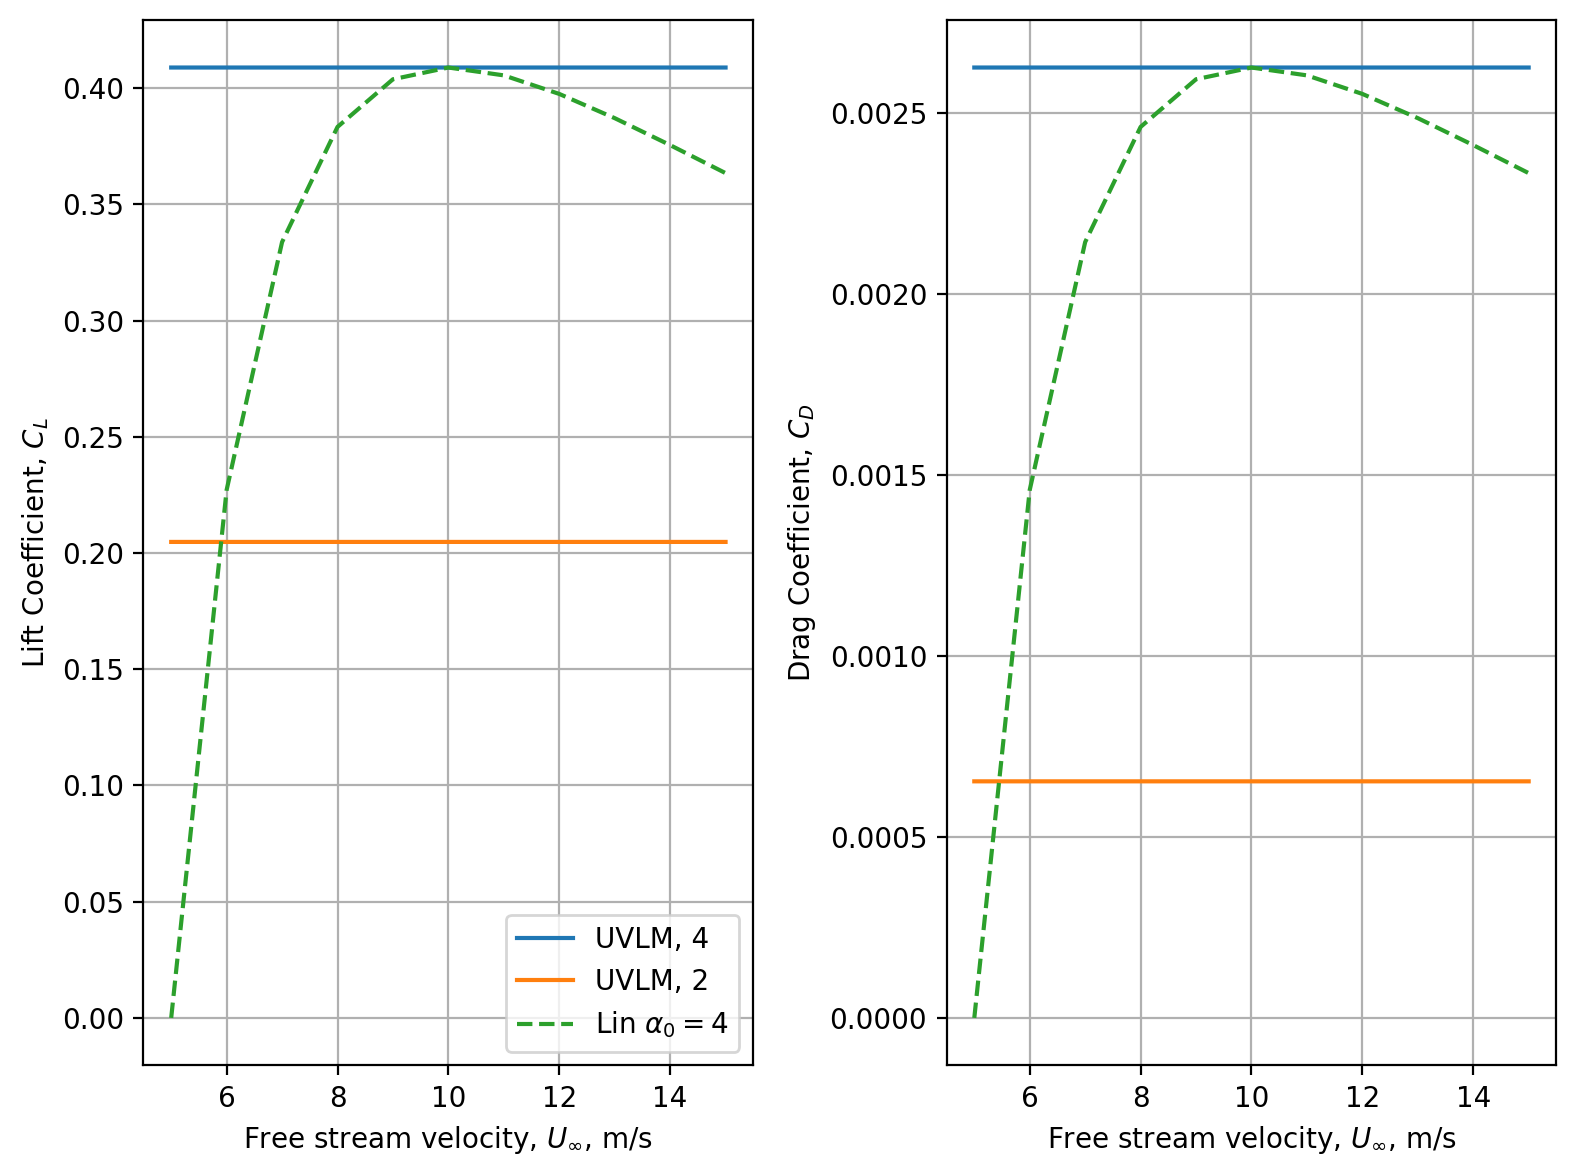

In [263]:
fig, ax = plt.subplots(ncols=2)

for case in uvlm_data:
    ax[0].plot(case['data'][:, 0], case['data_nondim'][:, -1], label='UVLM, {:g}'.format(case['alpha']))
    ax[1].plot(case['data'][:, 0], case['data_nondim'][:, 0])


for case in linear_systems:
    if case['alpha0'] == 2:
        continue
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    ax[0].plot(case['data_qs'][:, 0], case['data_qs'][:, -1], ls='--', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
    ax[1].plot(case['data_qs'][:, 0], case['data_qs'][:, 1], ls='--')
#     cla = (case['data_qs'][-1, -1] - case['data_qs'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CL_alpha = {:3f} / rad'.format(cla))
    
#     cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

ax[0].set_ylabel('Lift Coefficient, $C_L$')
ax[1].set_ylabel('Drag Coefficient, $C_D$')

ax[0].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')
ax[1].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')


plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()

Alpha0 = 4.0 deg


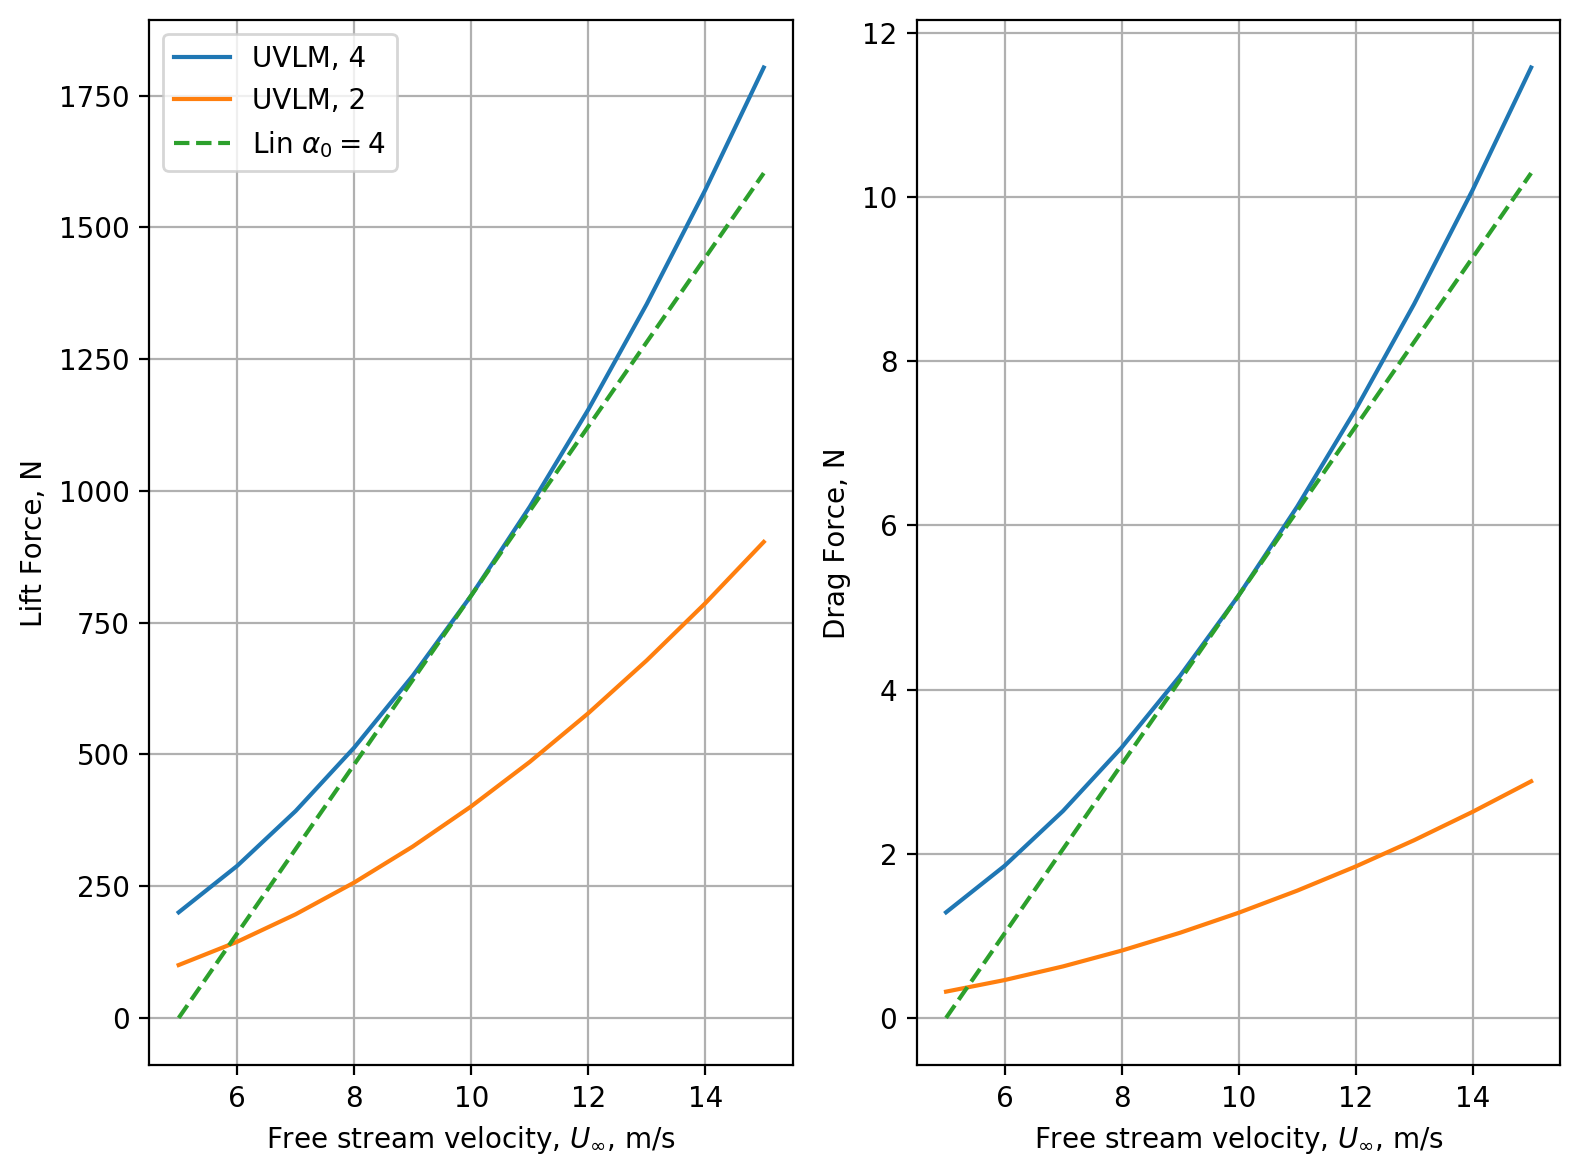

In [264]:
fig, ax = plt.subplots(ncols=2)

for case in uvlm_data:
    ax[0].plot(case['data'][:, 0], case['data'][:, -1], label='UVLM, {:g}'.format(case['alpha']))
    ax[1].plot(case['data'][:, 0], case['data'][:, 1])


for case in linear_systems:
    if case['alpha0'] == 2:
        continue
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    ax[0].plot(case['data_uinf_dim'][:, 0], case['data_uinf_dim'][:, -1], ls='--', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
    ax[1].plot(case['data_uinf_dim'][:, 0], case['data_uinf_dim'][:, 1], ls='--')
    
#     cla = (case['data_qs'][-1, -1] - case['data_qs'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CL_alpha = {:3f} / rad'.format(cla))
    
#     cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

ax[0].set_ylabel('Lift Force, N')
ax[1].set_ylabel('Drag Force, N')

ax[0].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')
ax[1].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')


plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()

# Scaled System

In [316]:
scaled_linear_systems = []

for alpha in [2]:
    case = {}
    case['alpha0'] = alpha
    case['case_name'] = 'simple_HALE_uvlm_alpha{:04g}_scaled_lm1_rom1_nmodes20'.format(case['alpha0']*100)
    case['path'] = path_to_systems + '/' + case['case_name']
    scaled_linear_systems.append(case)

In [317]:
b_chord = 0.5

In [318]:
def process_scaled_linear_dynamic_pressure(path_to_case, case_name, u_inf0, alpha0, dalpha, uinf_min, uinf_max, n_evals, return_freq='cl'):
    # load the aeroelastic system
    aoasys = scio.loadmat('{:s}/{:s}/{:s}.linss.mat'.format(path_to_case, case_name, case_name))
    # load the linearised uvlm
    uvlmsys = scio.loadmat('{:s}/{:s}/{:s}.uvlmss.mat'.format(path_to_case, case_name, case_name))
        
    # we need to compute the steady state transfer function of the discrete time uvlm
    H0 = uvlmsys['C'].dot(np.linalg.inv(np.eye(uvlmsys['A'].shape[0]) - uvlmsys['A']).dot(uvlmsys['B'])) + uvlmsys['D']
    
    cga = algebra.quat2rotation(algebra.euler2quat(np.array([0, alpha0, 0])))

    vx_ind = 20 # x_a input index
    vz_ind = 22 # z_a input index
    
    forces = np.zeros((n_evals, 4))
    alpha = alpha0 + dalpha  # rad

    for i_u_inf, duinf in enumerate(np.linspace(uinf_min, uinf_max, n_evals)-u_inf0):
        deuler = np.array([0, dalpha, 0])  # euler angle perturbation
        u_inf = u_inf0 + duinf  # actual velocity
        qS = 0.5 * rho * u_inf ** 2 * S_ref  

        euler0 = np.array([0, alpha0, 0])  # euler angle at the linearisation reference

        u = np.zeros((uvlmsys['B'].shape[1]))  # input vector
        V0 = np.array([-1, 0, 0], dtype=float) * u_inf  #G
        Vp = u_inf * np.array([-np.cos(dalpha), 0 , -np.sin(dalpha)])  #G
        
#         V0 /= np.linalg.norm(V0) / u_inf
#         Vp /= np.linalg.norm(Vp) / u_inf
#         print(np.linalg.norm(Vp))
    
        dvg = Vp - V0  # G

        dva = cga.T.dot(dvg)  # A
        
        dva /= u_inf / b_chord # actual u_inf
        
        dvz = dva[2]
        dvx = dva[0]
        
        # Need to scale the mode shapes by the rigid body mode factor
        u[vx_ind] = dvx / aoasys['mode_shapes'][-9,0]
        u[vz_ind] = dvz / aoasys['mode_shapes'][-7,2]
        
        # and the same with the output forces
        flin = H0.dot(u)[:3].real / aoasys['mode_shapes'][-9,0]  # A  (UVLM output)
        flin *= 0.5 * rho * u_inf ** 2 * b_chord ** 2  # force scaling with actual velocity
        F0A = aoasys['forces_aero_beam_dof'][0, :3] / aoasys['mode_shapes'][-9,0] * u_inf ** 2 # A - forces at the linearisation, scaled with the actual velocity
        LD0 = cga.dot(F0A)  # Lift and drag at the linearisation point
    
        forces[i_u_inf, 0] = u_inf
        LD = LD0 + algebra.der_Ceuler_by_v(euler0, F0A).dot(deuler) + cga.dot(flin)  # stability axes to get lift and drag
        if return_freq == 'cl':
            forces[i_u_inf, 1:] = LD / qS
        else:
            forces[i_u_inf, 1:] = LD
            
    return forces

In [319]:
for case in scaled_linear_systems:
    case['data_qs'] = process_scaled_linear_dynamic_pressure(case['path'], case['case_name'], u_inf0=10, alpha0=case['alpha0']*np.pi/180, dalpha=2*np.pi/180, uinf_min=5, uinf_max=15, n_evals=11, return_freq='cl')
    case['data_uinf_dim'] = process_scaled_linear_dynamic_pressure(case['path'], case['case_name'], u_inf0=10, alpha0=case['alpha0']*np.pi/180, dalpha=2*np.pi/180, uinf_min=5, uinf_max=15, n_evals=11, return_freq='dim')

Alpha0 = 2.0 deg


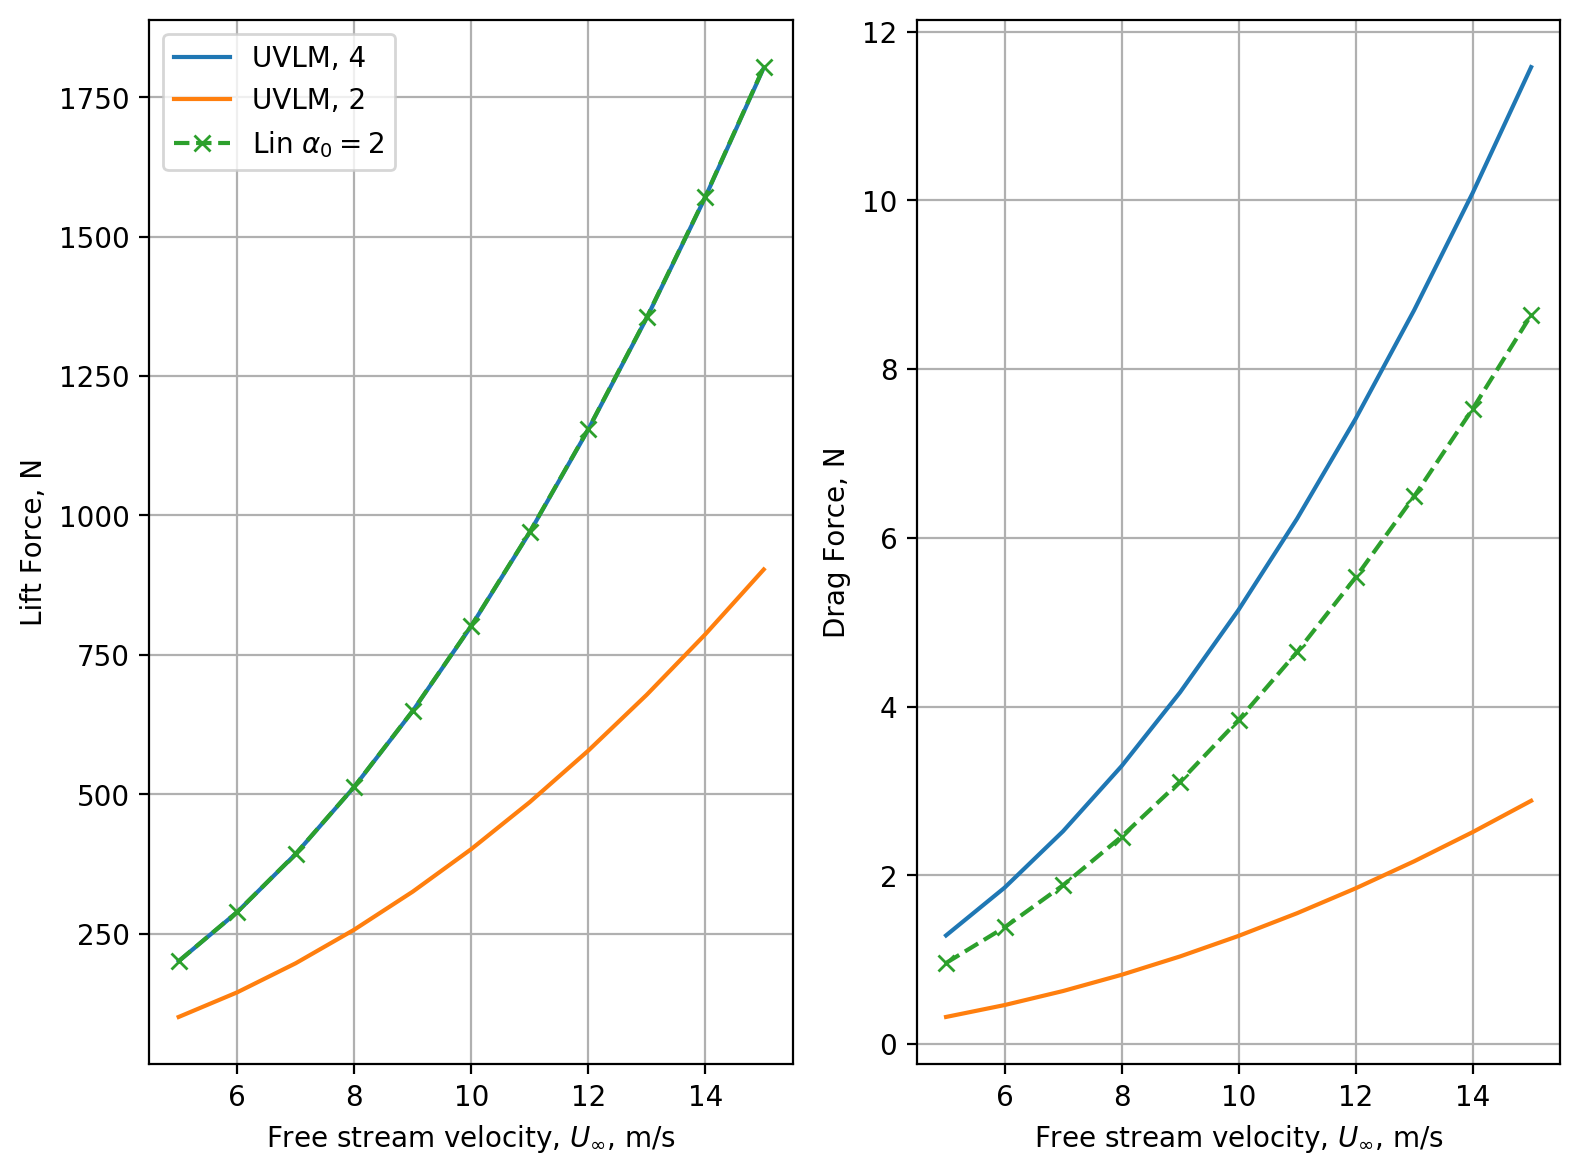

In [320]:
fig, ax = plt.subplots(ncols=2)

for case in uvlm_data:
    ax[0].plot(case['data'][:, 0], case['data'][:, -1], label='UVLM, {:g}'.format(case['alpha']))
    ax[1].plot(case['data'][:, 0], case['data'][:, 1])


for case in scaled_linear_systems:
#     if case['alpha0'] == 4:
#         continue
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    ax[0].plot(case['data_uinf_dim'][:, 0], case['data_uinf_dim'][:, -1], ls='--', marker='x', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
    ax[1].plot(case['data_uinf_dim'][:, 0], case['data_uinf_dim'][:, 1], ls='--', marker='x')
    
#     cla = (case['data_qs'][-1, -1] - case['data_qs'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CL_alpha = {:3f} / rad'.format(cla))
    
#     cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

ax[0].set_ylabel('Lift Force, N')
ax[1].set_ylabel('Drag Force, N')

ax[0].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')
ax[1].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')


plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()

Alpha0 = 2.0 deg


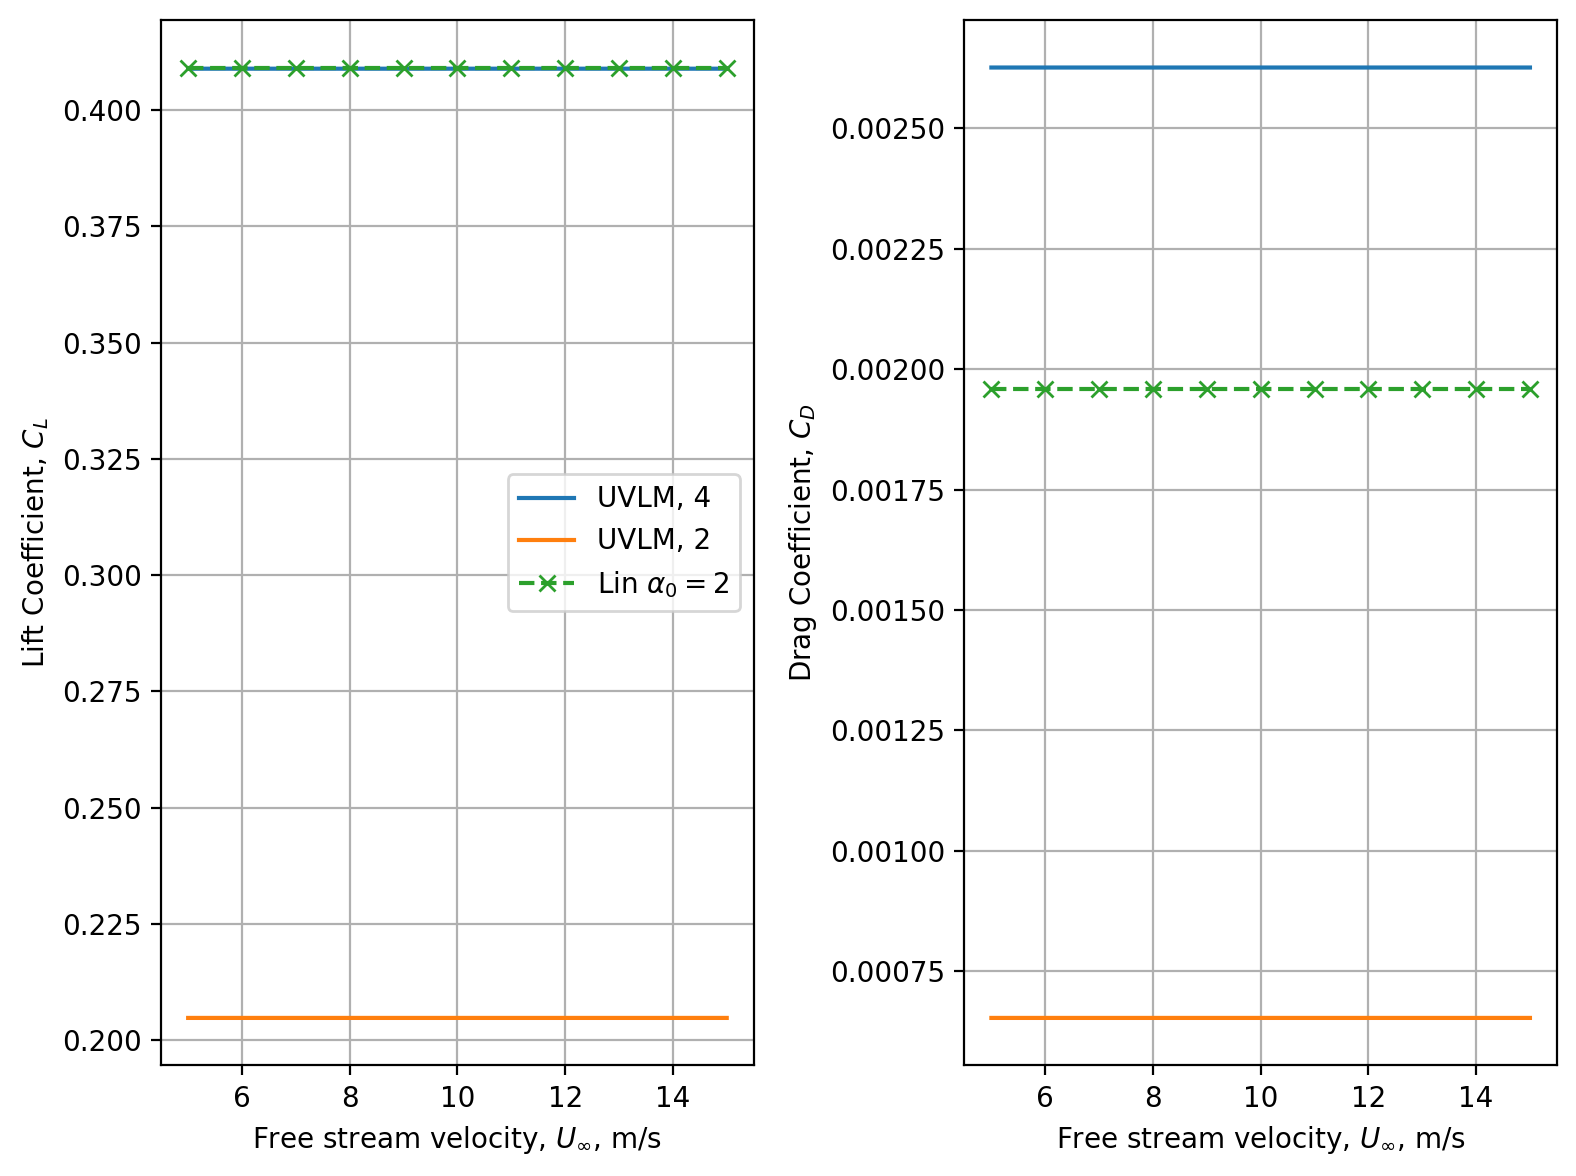

In [322]:
fig, ax = plt.subplots(ncols=2)

for case in uvlm_data:
    ax[0].plot(case['data'][:, 0], case['data_nondim'][:, -1], label='UVLM, {:g}'.format(case['alpha']))
    ax[1].plot(case['data'][:, 0], case['data_nondim'][:, 0])


for case in scaled_linear_systems:
#     if case['alpha0'] == 2:
#         continue
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    ax[0].plot(case['data_qs'][:, 0], case['data_qs'][:, -1], ls='--', marker='x', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
    ax[1].plot(case['data_qs'][:, 0], case['data_qs'][:, 1], ls='--', marker='x')
#     cla = (case['data_qs'][-1, -1] - case['data_qs'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CL_alpha = {:3f} / rad'.format(cla))
    
#     cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
#     print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

ax[0].set_ylabel('Lift Coefficient, $C_L$')
ax[1].set_ylabel('Drag Coefficient, $C_D$')

ax[0].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')
ax[1].set_xlabel(r'Free stream velocity, $U_\infty$, m/s')


plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()